In [1]:
import matplotlib.pyplot as plt
import matplotlib
# The line below allows to print all the outputs of a cell instead of only the last one
%config InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import os
import pandas as pd
# noinspection PyPackageRequirements
# noinspection PyPackageRequirements
import seaborn as sns
import sys
# noinspection PyPackageRequirements

import yaml

import pickle
import pathlib

import mlflow

from barl.envs import lorenz_new
import random

matplotlib.rcParams.update({'font.size': 14})

2023-12-09 16:06:24.317971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 16:06:24.490145: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-09 16:06:24.529401: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-09 16:06:24.529412: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

from_script = False

print(f"WARNING: This notebook is set with from_script = {from_script}.")

if from_script:
    # Get the path of the notebook config file from the environment variable
    path_config_notebook = os.environ["PATH_YAML_CONFIG"]
    # Load the notebook config file
    with open(path_config_notebook, "r") as file:
        dict_config_notebook = yaml.safe_load(file)
    id_xp = dict_config_notebook["id_xp"]
    path_project = pathlib.Path(dict_config_notebook["path_project"])
else:
    id_xp = 23
    path_project = pathlib.Path("/home/hosseinkhan/Documents/work/phd/git_repositories/doe4rl")

# Add the path of the project to the sys.path in order to import the modules in the src folder
sys.path.insert(0, os.path.abspath(path_project))

# Define the paths
path_mlruns = pathlib.Path(f"{path_project}/experiments/mlruns")
path_experiment = pathlib.Path(f"{path_mlruns}/{id_xp}")

# Set MLflow tracking URI
mlflow.set_tracking_uri(path_mlruns)

# Get all folder in the mlruns/id_xp directory except the folder 'tags' using pathlib and iter dir
list_id_hash = [path.name for path in path_experiment.iterdir() if path.is_dir() and path.name != "tags"]

print(f"Number of runs: {len(list_id_hash)} \n")
print(f"XP id: {id_xp} \n")

nested_dict_config = {}
list_df_config_flattened = []
# Verify all experiments are done on the same environment:
path_xp = f"{path_mlruns}/{id_xp}"
for name_id in list_id_hash:
    # list_glob_config = list(pathlib.Path(f"{path_xp}/{name_id}/artifacts/hydra_config").glob("./*/.hydra/config.yaml"))
    # assert len(list_glob_config) == 1, "More than one config file in the directory."

    # name_config_file = list_glob_config[0].name
    # Check if the file is a yaml file
    # assert name_config_file.endswith(".yaml"), "File is not a yaml file."

    # path_run_config_yaml = list_glob_config[0]

    dict_config_temp = mlflow.get_run(name_id).data.params
    nested_dict_config[name_id] = dict_config_temp
    list_df_config_flattened.append(pd.json_normalize(dict_config_temp, sep="_"))

    # with open(path_run_config_yaml, "r") as file:
    # Get the config file as a dictionary
    # dict_config_temp = yaml.safe_load(file)
    # Add the config file to the nested dictionary
    # nested_dict_config[name_id] = dict_config_temp
    # Flatten the config file for easier check
    # list_df_config_flattened.append(pd.json_normalize(dict_config_temp, sep="_"))
    # del dict_config_temp

# Check afterwards if all the configurations are the same
set_expected_nonunique_keys = {"alg_num_iters",
                               "crop_to_domain",
                               "project_to_domain",
                               "alg_n_semimarkov_dt",
                               "seed",
                               "name",
                               "_id"}

set_nonunique_keys = set(pd.concat(list_df_config_flattened)
                         .astype(str)
                         .nunique()
                         .loc[lambda x: x > 1]
                         .to_dict()
                         .keys())

print(f"Set of non unique keys: {set_nonunique_keys} \n")

# Check if the configurations are the same inter runs
bool_similar_configs = set_nonunique_keys.issubset(set_expected_nonunique_keys)
assert bool_similar_configs, "The configurations are not the same."

# Pretty print the first config file
print(f"First config file: {list_id_hash[0]} \n")
print(yaml.dump(nested_dict_config[list_id_hash[0]], sort_keys=False))

(pd.concat(list_df_config_flattened, keys=list_id_hash)
 .astype(str)
 # .groupby(["seed", "alg_n_semimarkov_dt"])
 # .loc[:, ["alg_num_iters", "crop_to_domain", "project_to_domain", "alg_n_semimarkov_dt", "seed", "name"]]
 .loc[:, ["alg_num_iters", "alg_n_semimarkov_dt", "seed", "name"]]
 .nunique()

 )

list_name_columns_learning = ["Acquisition Function Value",
                              "Eval Returns",
                              "Eval ndata",
                              "mean_difference_state_boostrap",
                              "n_corresponding_dt",
                              "Model MSE (current real MPC)",
                              "Model MSE (random test set)",
                              "Model MSE (GT MPC)",
                              "Model Likelihood (random test set)",
                              "Model Likelihood (GT MPC)", ]

dict_columns_learning_renaming_map = {"Acquisition Function Value": "eig",
                                      "Eval Returns": "eval_returns",
                                      "Eval ndata": "eval_ndata",
                                      "mean_difference_state_boostrap": "mean_difference_state_bootstrap",
                                      "Model MSE (current real MPC)": "model_mse_current_real_mpc",
                                      "Model MSE (random test set)": "model_mse_random_test_set",
                                      "Model MSE (GT MPC)": "model_mse_gt_mpc",
                                      "Model Likelihood (random test set)": "model_likelihood_random_test_set",
                                      "Model Likelihood (GT MPC)": "model_likelihood_gt_mpc", }
# Get the first dict_config
dict_config_ref = nested_dict_config[list_id_hash[0]]
# Length of the exploration trajectory
length_trajectory = int(dict_config_ref["num_iters"]) + 1
n_eval_trajectory = int(dict_config_ref["num_eval_trials"])
# Load each of the runs data
list_df_learning_data = []

for name_id in list_id_hash:
    path_pickle_data = f"{path_experiment}/{name_id}/barl_data/info.pkl"

    # Load the data
    with open(path_pickle_data, "rb") as file:
        dict_data = pickle.load(file)

        list_array = []
        eval_frequency = int(nested_dict_config[name_id]["eval_frequency"])

        list_excluded_columns_reshape = ["Acquisition Function Value",
                                         "mean_difference_state_boostrap",
                                         "n_corresponding_dt"]

        dict_temp = \
            {name_column: pd.Series(
                dict_data[name_column],
                index=([0, ] + list(np.arange(1, length_trajectory, step=eval_frequency, dtype=int))))

                for name_column in list_name_columns_learning
                if name_column not in list_excluded_columns_reshape}
        # Add the excluded columns without reshaping
        dict_temp.update(
            {name_column: pd.Series(dict_data[name_column], index=np.arange(length_trajectory - 1))
             for name_column in list_excluded_columns_reshape})
        df_learning_data_temp = (
            pd.DataFrame(dict_temp)
            .explode("Eval Returns")
            .reset_index(names=["iteration"])
            .rename(columns=dict_columns_learning_renaming_map)
        )

    list_df_learning_data.append(df_learning_data_temp)

# Get the list of the delay mode
list_action_delay_mode = [int(nested_dict_config[name_id]["alg_n_semimarkov_dt"])
                          for name_id in list_id_hash]

list_keys_tuple_id_action_delay_mode = [(run_id, action_delay_mode)
                                        for run_id, action_delay_mode
                                        in zip(list_id_hash, list_action_delay_mode)]

df_learning_data = pd.concat(list_df_learning_data, keys=list_keys_tuple_id_action_delay_mode,
                             names=["run_id", "action_delay_mode"])

In [2]:
str_yaml_config = \
    """
    dict_pde_config:
      ep_length: 500
      dt: 0.05
      control_step_freq: 1
      rho: 28
      sigma: 10
      beta: 2.67
    dict_sensing_actuation_config:
      actuation_type: full
      sensing_type: full_observation
      sensor_std: 0.0
    dict_init_condition_config:
      init_cond_type: random
      init_cond_scale: 1
      index_start_equilibrium: 1
    dict_reward_config:
      state_reward:
        reward_type: square_l2_norm
      control_penalty:
        control_penalty_type: square_l2_norm
        parameters:
          control_penalty_scale: 0.0
    dict_scaling_constants:
      observation: 1
      state: 1
      action: 10
    path_rendering: null
    path_output_data: null
    dtype: float64
    """

In [3]:
# Set the seed and fix the seeds
seed = 94
np.random.seed(seed)
random.seed(seed)

# Load the config file
dict_config_env = yaml.safe_load(str_yaml_config)

# Create the environment
gym_env = lorenz_new.LorenzEnvNew(seed=seed, **dict_config_env)

list_action_intensity = [0, 1, 2]

dim_state = gym_env.observation_space.shape[0]
ep_length = gym_env.ep_length

# Number of iid trajectories
n_iid_trajectories = 40

nd_array3d_trajectories = np.zeros((ep_length + 1, dim_state, len(list_action_intensity), n_iid_trajectories))

# Generate the trajectories
for l, action_intensity in enumerate(list_action_intensity):
    for i in range(n_iid_trajectories):
        gym_env.reset()
        gym_env.seed(seed + i)
        for t in range(ep_length):
            array_action = gym_env.action_space.sample() * action_intensity
            array_state, _, _, _, _ = gym_env.step(array_action)
            nd_array3d_trajectories[t, :, l, i] = array_state

df_test = pd.concat(
    [pd.concat([pd.DataFrame(nd_array3d_trajectories[:, :, l, i],
                             columns=pd.MultiIndex.from_product([["state"], [0, 1, 2]], names=["state", "dim_state"]))
                for l in range(len(list_action_intensity))],
               axis=1, keys=list_action_intensity, names=["action_intensity"])
     for i in range(n_iid_trajectories)], axis=0, keys=list(range(n_iid_trajectories)), names=["trajectory_id"])


(array([ -6.73780543, -10.67400354,  26.00027663]), {})

(array([-9.50019532, -8.45953934, 26.99497826]), {})

(array([-8.03141744, -8.58371004, 27.21884109]), {})

(array([-9.21487384, -7.43073519, 28.01739527]), {})

(array([-9.22689422, -8.45566904, 26.98856415]), {})

(array([-8.46570373, -8.96523297, 25.93353557]), {})

(array([-7.42761225, -8.32349012, 26.42596477]), {})

(array([-8.8595021 , -8.47786057, 27.37314397]), {})

(array([-9.4595472 , -8.79109376, 28.12291534]), {})

(array([-9.34135302, -7.82179936, 25.5672601 ]), {})

(array([-8.59319276, -8.00325369, 26.66285012]), {})

(array([-8.198389  , -8.64978057, 26.72798267]), {})

(array([-7.9341137 , -6.64199124, 26.4243808 ]), {})

(array([-7.59152466, -8.38739152, 27.64547496]), {})

(array([-8.3068301 , -8.33503525, 27.52693667]), {})

(array([-9.24596606, -7.83726669, 25.03663363]), {})

(array([-10.98968647,  -6.81916993,  25.73129827]), {})

(array([-9.1223898 , -8.48295149, 27.71377022]), {})

(array([-7.14854932, -7.89929203, 28.6269966 ]), {})

(array([-9.95037841, -8.56081139, 29.20785689]), {})

(array([ -8.88822598, -10.67677987,  25.58503881]), {})

(array([-9.16302437, -7.29211873, 28.41591838]), {})

(array([-8.2013806 , -8.08432537, 27.68404141]), {})

(array([ -8.62348464, -10.30800729,  26.95082091]), {})

(array([-8.59909755, -8.90285696, 26.16653457]), {})

(array([-6.92486527, -9.02889599, 27.88482633]), {})

(array([-7.62787151, -9.31583742, 26.41418158]), {})

(array([-8.71940739, -8.51947564, 26.75403858]), {})

(array([-8.67856862, -8.33457738, 26.65118948]), {})

(array([-9.14151585, -8.72821416, 27.15899787]), {})

(array([-6.4803833 , -8.19641047, 26.51343599]), {})

(array([-8.37507395, -7.37973497, 26.69856884]), {})

(array([-7.73956885, -9.27702765, 26.7700987 ]), {})

(array([-8.98547082, -7.75788856, 27.75885824]), {})

(array([-8.21754997, -8.44754154, 26.82276266]), {})

(array([-9.21141332, -7.12951596, 27.32297644]), {})

(array([-9.06974458, -8.02976836, 27.59563242]), {})

(array([-9.10128971, -7.35683482, 28.23838219]), {})

(array([-8.18082085, -8.10751573, 25.6099748 ]), {})

(array([-8.5422173 , -8.76685673, 25.68846533]), {})

(array([-6.83901779, -8.52101086, 26.65769735]), {})

(array([-8.43462223, -8.90935351, 24.70872693]), {})

(array([-8.61668572, -9.00365745, 26.1449597 ]), {})

(array([-8.55741312, -6.2055462 , 26.76359023]), {})

(array([-9.83571826, -7.64452722, 27.89281546]), {})

(array([ -8.8615727 , -10.09036574,  28.18287113]), {})

(array([-8.08208286, -8.40289232, 26.72616871]), {})

(array([-7.43247691, -8.34642977, 27.83575645]), {})

(array([-8.76194   , -9.89252404, 25.88451542]), {})

(array([-8.26286462, -7.03255412, 27.29274551]), {})

(array([-9.2997619 , -9.41910608, 25.61921611]), {})

(array([-8.98037722, -7.80151636, 27.3463942 ]), {})

(array([-9.14178235, -9.30685428, 26.20618898]), {})

(array([-10.0726542 ,  -9.52551169,  26.17506419]), {})

(array([-9.34358893, -9.65906569, 26.80073802]), {})

(array([-7.57863087, -7.63375479, 26.06270299]), {})

(array([-11.15445042,  -8.21258574,  25.75103692]), {})

(array([-8.93909596, -8.12225868, 26.79525072]), {})

(array([-9.48343747, -6.56323145, 28.27135311]), {})

(array([-8.17628931, -8.55252169, 28.4706421 ]), {})

(array([-8.90145989, -8.69063924, 25.40298175]), {})

(array([-9.67187901, -8.40502658, 27.62098186]), {})

(array([-9.52696053, -7.91685612, 25.94627484]), {})

(array([-8.28467912, -7.51279906, 29.03775294]), {})

(array([-9.2012257 , -8.69577643, 27.11496598]), {})

(array([-9.35115271, -9.1356731 , 27.0631989 ]), {})

(array([-9.22970957, -7.28238887, 26.21955243]), {})

(array([ -6.23757827, -10.52180242,  27.06004757]), {})

(array([-9.09759253, -7.78017209, 29.18566674]), {})

(array([-7.23645712, -8.31153499, 26.81494804]), {})

(array([-7.52154518, -8.52771258, 25.99915365]), {})

(array([-10.95251428, -10.7706022 ,  28.29866163]), {})

(array([-9.78776138, -9.65308151, 27.79488637]), {})

(array([ -6.58776433, -10.1853391 ,  26.92784631]), {})

(array([-6.35476493, -8.45887318, 27.45150972]), {})

(array([-8.30307637, -9.68539408, 28.19475175]), {})

(array([-8.85808001, -7.59543699, 26.99781321]), {})

(array([-9.07031871, -7.63220072, 26.46108318]), {})

(array([-7.79562021, -6.94327654, 28.17553348]), {})

(array([-10.35563042,  -6.82016994,  27.78553856]), {})

(array([-8.63233488, -8.77509117, 26.73791011]), {})

(array([-7.90324053, -8.16554743, 26.67818419]), {})

(array([ -8.65212874, -10.5296512 ,  26.14269564]), {})

(array([-9.84482981, -7.60886955, 26.26890422]), {})

(array([-9.55213315, -8.25418053, 26.55758701]), {})

(array([-9.82897558, -7.06631831, 27.82055492]), {})

(array([ -9.0561344 , -10.10413007,  27.88223812]), {})

(array([-9.3931116 , -7.90163412, 26.81446719]), {})

(array([-8.2883094 , -7.57712886, 27.24440618]), {})

(array([-9.80054014, -8.57853409, 28.69519808]), {})

(array([-7.00354586, -9.10983046, 26.70876211]), {})

(array([-8.27336763, -6.84812806, 26.54405807]), {})

(array([-7.93160572, -9.08900764, 26.76184278]), {})

(array([-8.79870641, -9.8976744 , 28.86871027]), {})

(array([-9.25668423, -7.35250898, 27.05349616]), {})

(array([-7.59316325, -7.52340919, 26.06610586]), {})

(array([-8.81066081, -8.3558453 , 27.18747516]), {})

(array([ -7.37932178, -10.08147995,  24.82656461]), {})

(array([ -7.68317164, -10.52681232,  26.96083373]), {})

(array([-8.66207689, -7.21245811, 27.75789413]), {})

(array([-7.10017746, -8.42348736, 28.04300843]), {})

(array([-6.88046398, -9.12439172, 27.06486607]), {})

(array([-9.12287029, -9.3680658 , 28.04090983]), {})

(array([-8.3584045 , -7.67618412, 25.69045048]), {})

(array([-7.51101835, -7.14372504, 27.37548967]), {})

(array([-7.80320447, -9.14039894, 29.08856813]), {})

(array([-8.61166906, -7.70126493, 27.51686844]), {})

(array([-10.25225404,  -8.04880027,  26.78989399]), {})

(array([-9.26665489, -7.98139932, 25.3544539 ]), {})

(array([-6.99694701, -8.1116424 , 27.97864906]), {})

(array([-10.5657286 ,  -9.81618315,  24.65461433]), {})

(array([-8.01976236, -8.62062683, 27.89790019]), {})

(array([-9.53175824, -9.094811  , 27.26752535]), {})

(array([-8.11923483, -8.34873628, 26.84648199]), {})

(array([ -9.94807082, -10.21499129,  27.5392941 ]), {})

(array([-7.94892099, -8.26208534, 26.74327343]), {})

(array([-6.1830343 , -8.97541251, 27.59779611]), {})

(array([-7.56140589, -7.4215949 , 26.52014973]), {})

(array([-8.90719611, -9.97136002, 25.83714775]), {})

(array([-7.46090263, -9.11944353, 24.51305511]), {})

<AxesSubplot: >

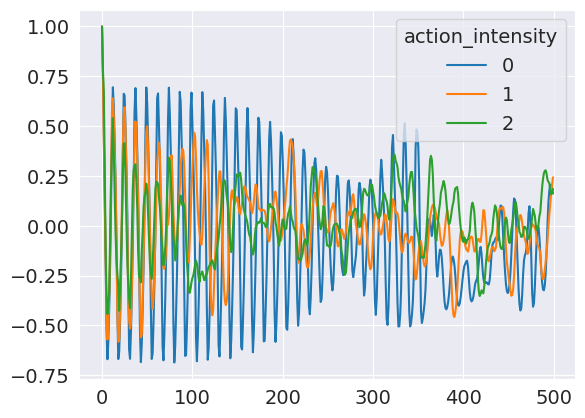

In [4]:
(df_test
 .stack(level=["action_intensity", "state"])[0]
 .unstack(level=1)
 .groupby("action_intensity")
 .corr()
 .loc[:, 0]
 .unstack(0)
 .plot())

<AxesSubplot: >

idx_state 0
intensity 0


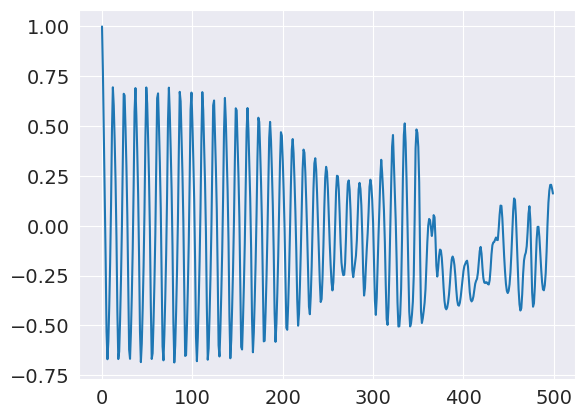

<AxesSubplot: >

idx_state 0
intensity 1


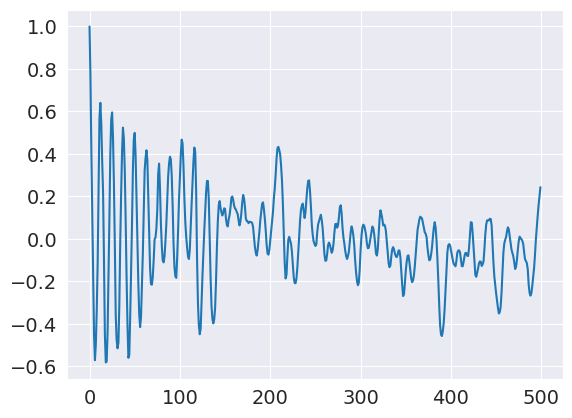

<AxesSubplot: >

idx_state 0
intensity 2


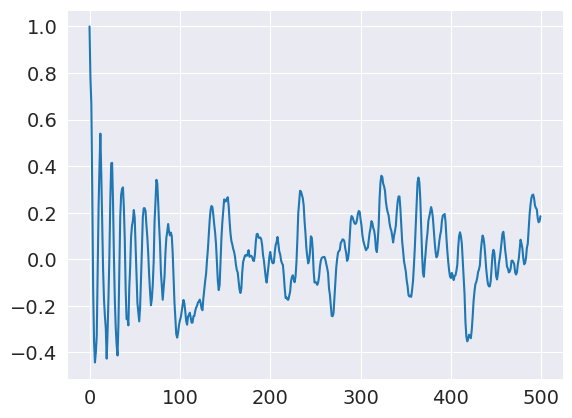

<AxesSubplot: >

idx_state 1
intensity 0


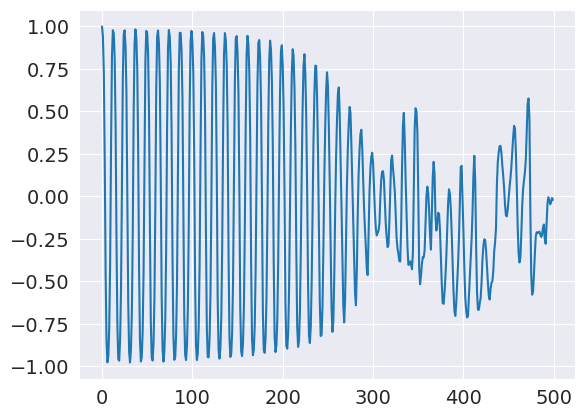

<AxesSubplot: >

idx_state 1
intensity 1


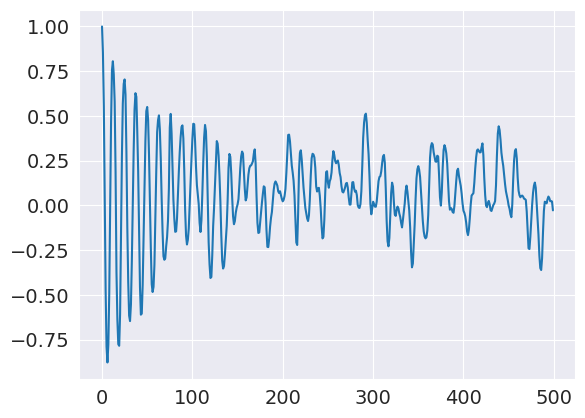

<AxesSubplot: >

idx_state 1
intensity 2


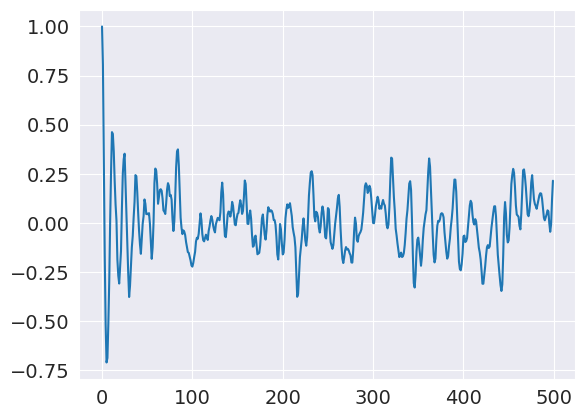

<AxesSubplot: >

idx_state 2
intensity 0


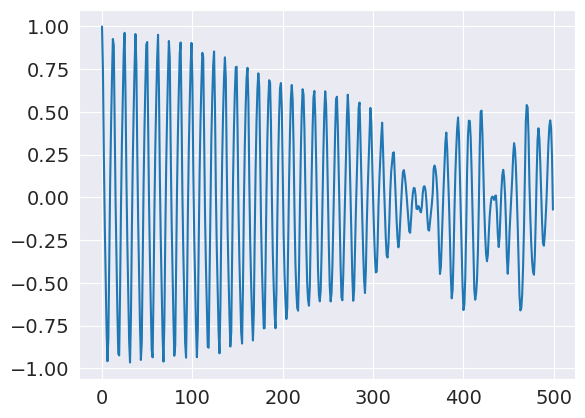

<AxesSubplot: >

idx_state 2
intensity 1


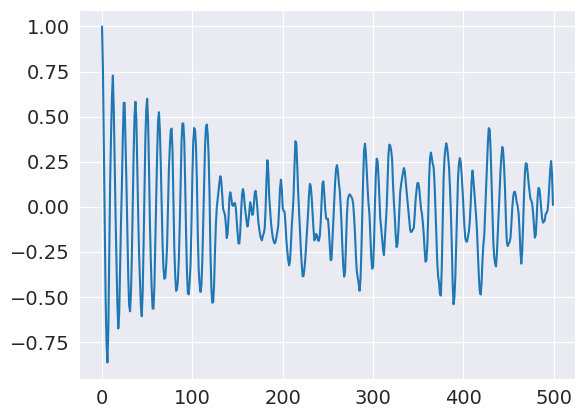

<AxesSubplot: >

idx_state 2
intensity 2


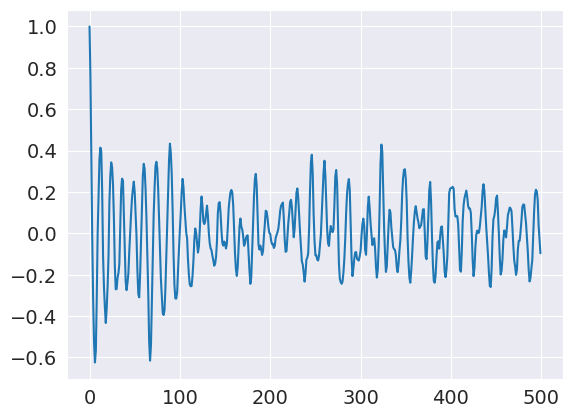

In [5]:
for idx_state in range(dim_state):
    for idx_intensity in range(len(list_action_intensity)):

        (df_test
         .stack(level=["action_intensity", "state"])[idx_state]
         .unstack(level=1)
         .groupby("action_intensity")
         .corr()
         .loc[idx_intensity, 0]
         .plot()
         )
        print(f"idx_state {idx_state}")
        print(f"intensity {list_action_intensity[idx_intensity]}")
        plt.show()

<AxesSubplot: >

idx_state 0
intensity 0


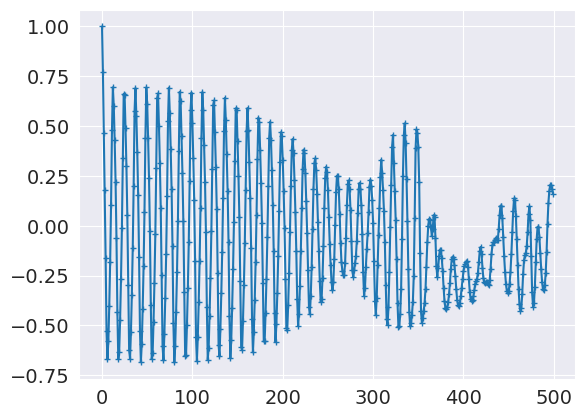

<AxesSubplot: >

idx_state 0
intensity 1


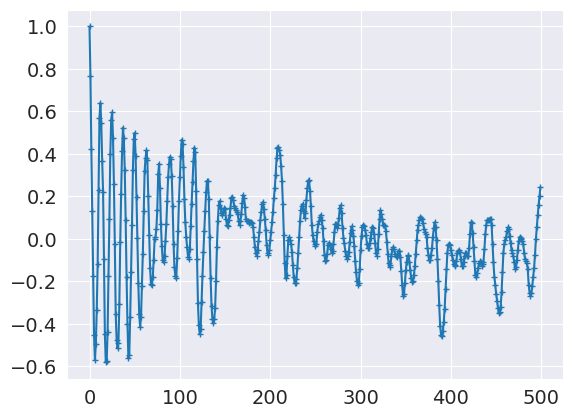

<AxesSubplot: >

idx_state 0
intensity 2


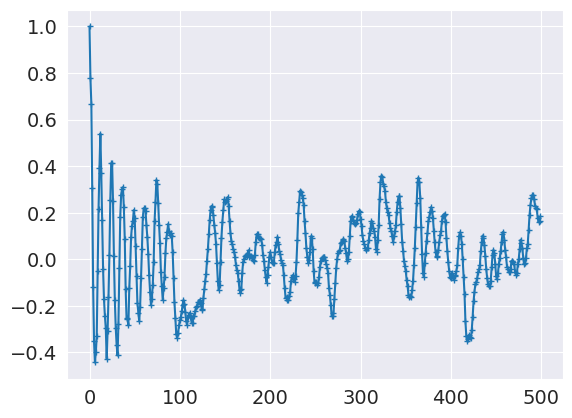

<AxesSubplot: >

idx_state 1
intensity 0


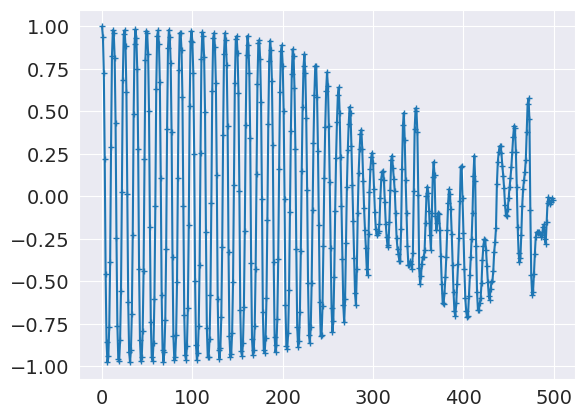

<AxesSubplot: >

idx_state 1
intensity 1


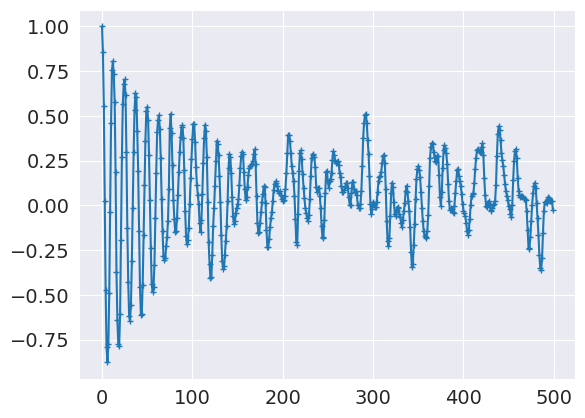

<AxesSubplot: >

idx_state 1
intensity 2


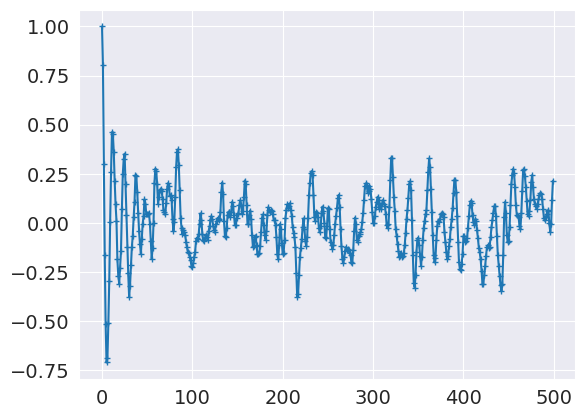

<AxesSubplot: >

idx_state 2
intensity 0


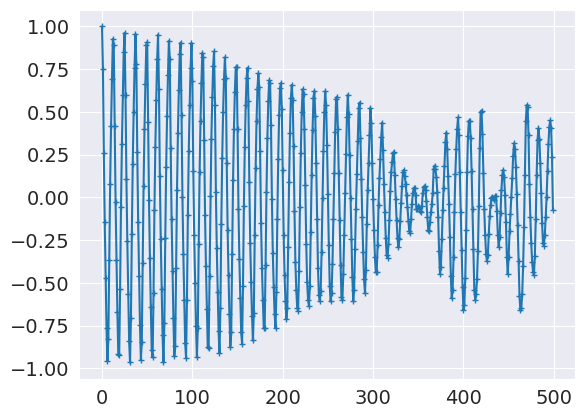

<AxesSubplot: >

idx_state 2
intensity 1


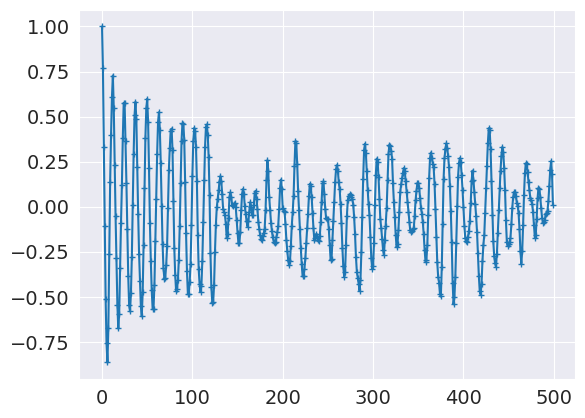

<AxesSubplot: >

idx_state 2
intensity 2


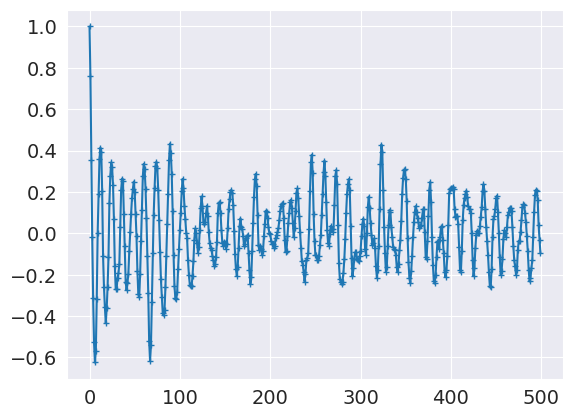

In [6]:
for idx_state in range(dim_state):
    for idx_intensity in range(len(list_action_intensity)):

        (df_test
         .stack(level=["action_intensity", "state"])[idx_state]
         .unstack(level=1)
         .groupby("action_intensity")
         .corr()
         .loc[idx_intensity, 0]
         .plot(marker="+", ms=5)
         )
        print(f"idx_state {idx_state}")
        print(f"intensity {list_action_intensity[idx_intensity]}")
        plt.show()

### Test

<AxesSubplot: xlabel='action_intensity,state,None'>

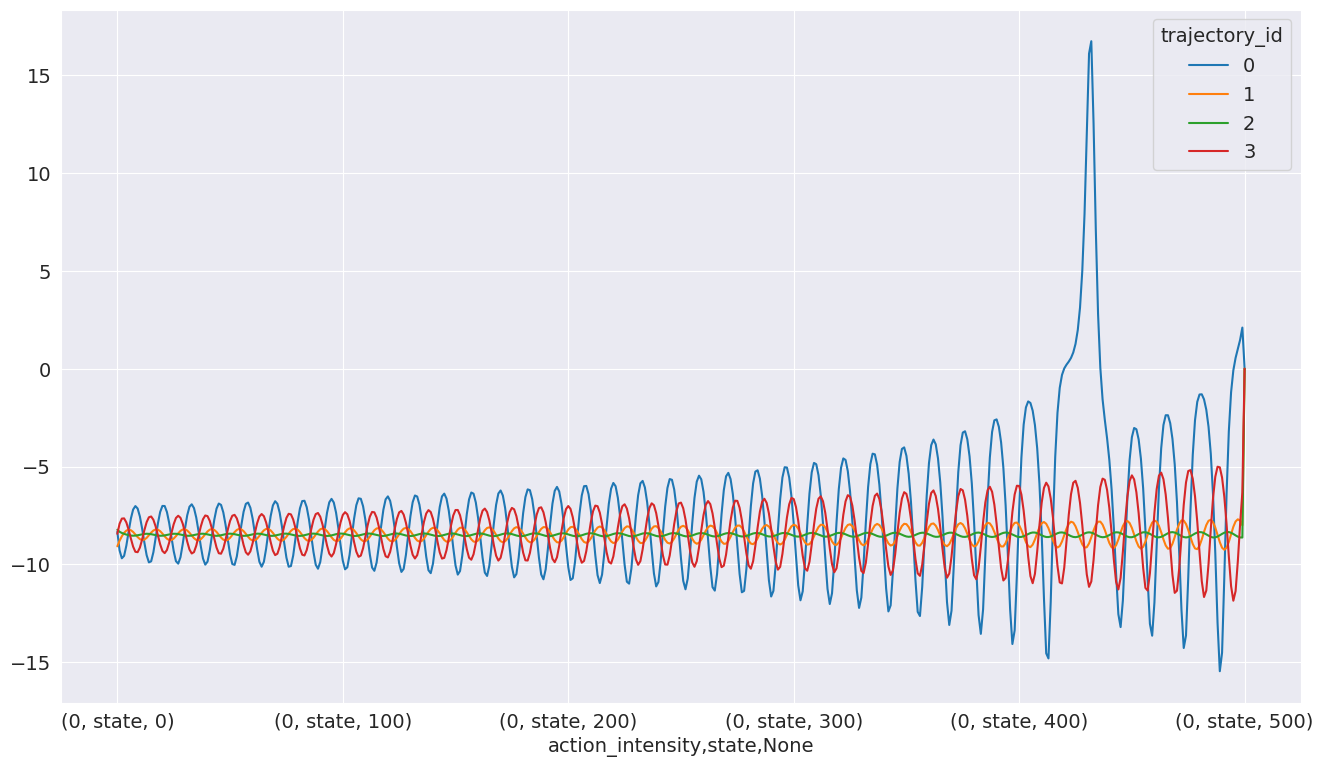

In [7]:
(df_test
 .stack(level=["action_intensity", "state"])[0]
 .unstack(level=1)
 # .corr()
 # .groupby("action_intensity")
 .loc[pd.IndexSlice[:3, 0, :]]
 .stack()
 .unstack(0)
 # .reset_index(drop=True)
 # .corr()
 # .loc[0]
 .plot(figsize=(16,9))
 )

<AxesSubplot: >

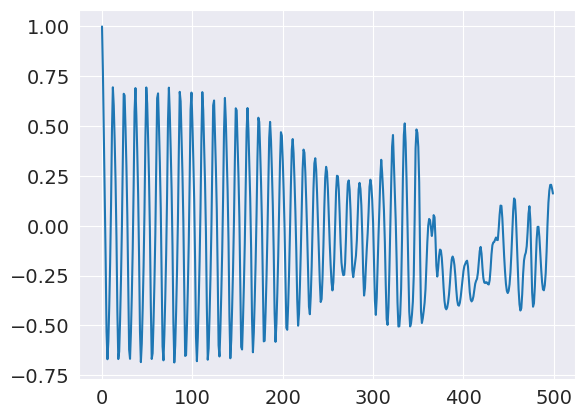

In [8]:
# Verifies the correlation

(df_test
 .stack(level=["action_intensity", "state"])[0]
 .unstack(level=1)
 # .corr()
 # .groupby("action_intensity")
 .loc[pd.IndexSlice[:, 0, :]]
 .corr()
 .loc[0]
 .plot())

### Final plot

In [9]:
list(range(100, 10, -3))

[100,
 97,
 94,
 91,
 88,
 85,
 82,
 79,
 76,
 73,
 70,
 67,
 64,
 61,
 58,
 55,
 52,
 49,
 46,
 43,
 40,
 37,
 34,
 31,
 28,
 25,
 22,
 19,
 16,
 13]

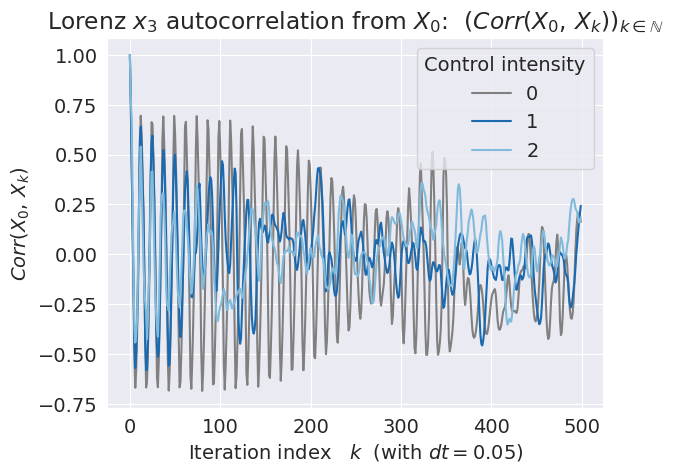

In [10]:
from matplotlib import cm, colors

path_save_fig = "/home/hosseinkhan/Documents/work/phd/latex_documents/l4dc2024_latex_template_semimarkov/images"
folder_name = "lorenz_autocorrelation_x3"
path_save_fig = f"{path_save_fig}/{folder_name}"
pathlib.Path(path_save_fig).mkdir(parents=True, exist_ok=True)

cmap = cm.get_cmap("Blues_r", 10)
array_cmap = cmap(range(0, 10))
array_cmap[0, :] = colors.to_rgba("gray")
array_new_cmap = colors.ListedColormap(array_cmap[[0, 2, 5]])

axesSubplot = (df_test
 .stack(level=["action_intensity", "state"])[0]
 .unstack(level=1)
 .groupby("action_intensity")
 .corr()
 .loc[:, 0]
 .unstack(0)
 .plot(title="Lorenz $x_3$ autocorrelation from $X_0$:  $(Corr(X_0,\\, X_k))_{k \\in \\mathbb{N}}$",
       xlabel="Iteration index   $k$  (with $dt = 0.05$)",
       ylabel="$Corr(X_0,\\, X_k)$",
       colormap=array_new_cmap
               ))
axesSubplot.get_legend().set_title("Control intensity")

# Save the figure
plt.savefig(f"{path_save_fig}/lorenz_autocorrelation_x3.png", bbox_inches="tight")

# g.ticklabel_format(axis="y", st
# axesSubplot.set_title("d")